# Uncovering Global Development Patterns (2010–2020)

### EDA
The exploratory data analysis (EDA) is done on multi-domain World Development Indicators (WDI) data (2010–2020 averages) across:

- Economy & Growth  
- Health  
- Education  
- Agriculture & Rural Development  
- Environment  
- Infrastructure  

Goals:

1. Understand data quality (missingness, coverage).
2. Study distributions & skewness of indicators.
3. Explore correlations to detect redundancy.
4. Prepare a clean, interpretable feature set per domain.
5. Provide a clean, merged dataset for PCA & clustering.


In [2]:
# Imports & configuration
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from pathlib import Path

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

In [3]:
# folder path for data files
DATA_DIR = Path("/Users/madhurabn/Desktop/unsupervised learning/data")


file_map = {
    "education": DATA_DIR / "education.csv",
    "economy": DATA_DIR / "economy-and-growth.csv",
    "agriculture": DATA_DIR / "agriculture-and-rural-development.csv",
    "environment": DATA_DIR / "environment.csv",
    "health": DATA_DIR / "health.csv",
    "infrastructure": DATA_DIR / "infrastructure.csv",
}

datasets = {name: pd.read_csv(path) for name, path in file_map.items()}
list(datasets.keys())

['education',
 'economy',
 'agriculture',
 'environment',
 'health',
 'infrastructure']

### Basic overview per domain

In [4]:
summary_rows = []

for name, df in datasets.items():
    numeric = df.select_dtypes(include="number")
    missing_pct = numeric.isna().mean().mean() * 100
    
    summary_rows.append({
        "domain": name,
        "rows": df.shape[0],
        "columns": df.shape[1],
        "numeric_cols": numeric.shape[1],
        "avg_missing_pct_numeric": round(missing_pct, 2),
        "example_cols": df.columns[3:8].tolist()
    })

summary_df = pd.DataFrame(summary_rows)
summary_df

,domain,rows,columns,numeric_cols,avg_missing_pct_numeric,example_cols
0,education,2867,53,51,59.79,[average_value_Adolescents out of school (% of...
1,economy,2901,53,51,21.72,[average_value_DEC alternative conversion fact...
2,agriculture,2915,45,43,39.10,"[average_value_Access to electricity, rural (%..."
3,environment,2914,53,51,43.12,"[average_value_Adjusted net savings, excluding..."
4,health,2915,53,51,8.63,[average_value_Age dependency ratio (% of work...
5,infrastructure,2901,50,48,54.27,"[average_value_Air transport, freight (million..."


### Missingness – overview

In [5]:
def missingness_table(df, domain_name, top_n=20):
    numeric = df.select_dtypes(include="number")
    miss = numeric.isna().mean().sort_values(ascending=False) * 100
    tbl = miss.to_frame(name="missing_pct")
    tbl["missing_pct"] = tbl["missing_pct"].round(2)
    print(f"\n=== {domain_name.upper()} – Missingness (Top {top_n}) ===")
    return tbl.head(top_n)

for name, df in datasets.items():
    display(missingness_table(df, name, top_n=15))


=== EDUCATION – Missingness (Top 15) ===


,missing_pct
"average_value_Educational attainment, Doctoral or equivalent, population 25+, female (%) (cumulative)",90.86
"average_value_Educational attainment, Doctoral or equivalent, population 25+, male (%) (cumulative)",90.86
"average_value_Educational attainment, Doctoral or equivalent, population 25+, total (%) (cumulative)",90.83
"average_value_Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative)",87.83
"average_value_Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative)",87.83
"average_value_Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",87.76
"average_value_Educational attainment, at least completed short-cycle tertiary, population 25+, male (%) (cumulative)",81.44
"average_value_Educational attainment, at least completed short-cycle tertiary, population 25+, female (%) (cumulative)",81.44
"average_value_Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)",81.37
"average_value_Trained teachers in secondary education, male (% of male teachers)",79.04



=== ECONOMY – Missingness (Top 15) ===


,missing_pct
average_value_Gross savings (current US$),41.95
average_value_Gross savings (current LCU),41.95
average_value_Discrepancy in expenditure estimate of GDP (current LCU),36.02
average_value_Gross value added at basic prices (GVA) (constant LCU),35.99
average_value_Taxes less subsidies on products (constant LCU),35.57
average_value_Gross domestic savings (current LCU),34.51
average_value_Gross value added at basic prices (GVA) (current LCU),33.02
average_value_Taxes less subsidies on products (current US$),32.78
average_value_Taxes less subsidies on products (current LCU),32.71
average_value_Net secondary income (Net current transfers from abroad) (current US$),31.40



=== AGRICULTURE – Missingness (Top 15) ===


,missing_pct
average_value_Agricultural nitrous oxide emissions (% of total),100.00
"average_value_Agricultural machinery, tractors",100.00
"average_value_Agricultural machinery, tractors per 100 sq. km of arable land",100.00
average_value_Agricultural methane emissions (% of total),100.00
average_value_Rural land area where elevation is below 5 meters (% of total land area),92.25
average_value_Rural population living in areas where elevation is below 5 meters (% of total population),92.21
average_value_Rural land area (sq. km),92.21
average_value_Rural land area where elevation is below 5 meters (sq. km),92.21
average_value_Average precipitation in depth (mm per year),87.51
"average_value_Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)",85.63



=== ENVIRONMENT – Missingness (Top 15) ===


,missing_pct
average_value_Energy related methane emissions (% of total),100.00
average_value_Agricultural methane emissions (% of total),100.00
average_value_Nitrous oxide emissions in energy sector (% of total),100.00
average_value_Agricultural nitrous oxide emissions (% of total),100.00
average_value_Rural population living in areas where elevation is below 5 meters (% of total population),92.21
average_value_Population living in areas where elevation is below 5 meters (% of total population),92.21
average_value_Urban population living in areas where elevation is below 5 meters (% of total population),92.21
"average_value_Bird species, threatened",90.97
"average_value_Mammal species, threatened",90.97
"average_value_Fish species, threatened",90.97



=== HEALTH – Missingness (Top 15) ===


,missing_pct
average_value_Sex ratio at birth (male births per female births),16.98
average_value_Age dependency ratio (% of working-age population),8.99
"average_value_Population ages 55-59, male (% of male population)",8.99
"average_value_Population ages 60-64, female (% of female population)",8.99
"average_value_Population ages 60-64, male (% of male population)",8.99
average_value_Population ages 65 and above (% of total population),8.99
"average_value_Population ages 65 and above, female",8.99
"average_value_Population ages 65 and above, female (% of female population)",8.99
"average_value_Population ages 65 and above, male",8.99
"average_value_Population ages 65 and above, male (% of male population)",8.99



=== INFRASTRUCTURE – Missingness (Top 15) ===


,missing_pct
average_value_Public private partnerships investment in ICT (current US$),99.00
average_value_Investment in ICT with private participation (current US$),98.52
average_value_Investment in water and sanitation with private participation (current US$),95.62
average_value_Public private partnerships investment in water and sanitation (current US$),95.35
average_value_Public private partnerships investment in transport (current US$),89.56
average_value_Investment in transport with private participation (current US$),89.28
"average_value_Annual freshwater withdrawals, total (% of internal resources)",86.25
"average_value_Annual freshwater withdrawals, total (billion cubic meters)",85.94
"average_value_Annual freshwater withdrawals, industry (% of total freshwater withdrawal)",85.66
"average_value_Annual freshwater withdrawals, domestic (% of total freshwater withdrawal)",85.59


### Distributions & skewness across all domain

In [6]:
def skewness_table(df, domain_name, top_n=15):
    numeric = df.select_dtypes(include="number")
    skew = numeric.skew(numeric_only=True).sort_values(key=lambda s: s.abs(), ascending=False)
    tbl = skew.to_frame(name="skewness")
    tbl["abs_skew"] = tbl["skewness"].abs().round(3)
    tbl["skewness"] = tbl["skewness"].round(3)
    print(f"\n=== {domain_name.upper()} – Most Skewed Indicators (Top {top_n}) ===")
    return tbl.head(top_n)

for name, df in datasets.items():
    display(skewness_table(df, name, top_n=10))


=== EDUCATION – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
"average_value_Government expenditure per student, tertiary (% of GDP per capita)",9.145,9.145
"average_value_Secondary education, teachers",3.706,3.706
"average_value_Secondary education, vocational pupils",3.633,3.633
"average_value_Secondary education, teachers, female",3.625,3.625
"average_value_Current education expenditure, primary (% of total expenditure in primary public institutions)",-2.982,2.982
"average_value_Current education expenditure, total (% of total expenditure in public institutions)",-2.435,2.435
"average_value_Current education expenditure, secondary (% of total expenditure in secondary public institutions)",-2.330,2.330
"average_value_Current education expenditure, tertiary (% of total expenditure in tertiary public institutions)",-2.311,2.311
"average_value_Educational attainment, Doctoral or equivalent, population 25+, male (%) (cumulative)",2.227,2.227
"average_value_Educational attainment, Doctoral or equivalent, population 25+, female (%) (cumulative)",2.040,2.040



=== ECONOMY – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
average_value_DEC alternative conversion factor (LCU per US$),20.956,20.956
average_value_Discrepancy in expenditure estimate of GDP (current LCU),16.957,16.957
average_value_GDP per capita (current LCU),15.610,15.610
average_value_GNI per capita (current LCU),15.436,15.436
average_value_GDP deflator (base year varies by country),13.356,13.356
average_value_GDP (current LCU),12.818,12.818
average_value_GDP: linked series (current LCU),12.716,12.716
average_value_GNI (current LCU),12.692,12.692
average_value_GNI: linked series (current LCU),12.620,12.620
average_value_Gross domestic savings (current LCU),12.606,12.606



=== AGRICULTURE – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
average_value_Fertilizer consumption (% of fertilizer production),14.196,14.196
average_value_Fertilizer consumption (kilograms per hectare of arable land),7.172,7.172
average_value_Agricultural raw materials exports (% of merchandise exports),6.756,6.756
average_value_Arable land (hectares),5.745,5.745
average_value_Surface area (sq. km),4.938,4.938
average_value_Land area (sq. km),4.930,4.930
average_value_Agricultural land (sq. km),4.861,4.861
average_value_Rural population,4.797,4.797
average_value_Cereal yield (kg per hectare),4.705,4.705
average_value_Agricultural methane emissions (thousand metric tons of CO2 equivalent),4.690,4.690



=== ENVIRONMENT – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
average_value_Adjusted savings: mineral depletion (current US$),20.508,20.508
average_value_Coal rents (% of GDP),17.807,17.807
average_value_Natural gas rents (% of GDP),13.497,13.497
average_value_Methane emissions (% change from 1990),11.966,11.966
average_value_Nitrous oxide emissions (% change from 1990),11.908,11.908
average_value_Adjusted savings: net national savings (current US$),11.405,11.405
average_value_Adjusted savings: carbon dioxide damage (current US$),10.418,10.418
average_value_Adjusted savings: education expenditure (current US$),9.923,9.923
"average_value_Adjusted net savings, excluding particulate emission damage (current US$)",9.626,9.626
average_value_Adjusted savings: consumption of fixed capital (current US$),8.313,8.313



=== HEALTH – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
"average_value_Population, female (% of total population)",-5.286,5.286
"average_value_Population, male (% of total population)",5.286,5.286
"average_value_Population, total",4.973,4.973
"average_value_Population, female",4.741,4.741
"average_value_Population ages 15-64, female",4.736,4.736
"average_value_Population, male",4.732,4.732
"average_value_Population ages 15-64, total",4.732,4.732
"average_value_Population ages 15-64, male",4.729,4.729
"average_value_Population ages 65 and above, total",4.691,4.691
"average_value_Population ages 65 and above, female",4.690,4.690



=== INFRASTRUCTURE – Most Skewed Indicators (Top 10) ===


,skewness,abs_skew
average_value_Secure Internet servers,23.419,23.419
average_value_Secure Internet servers (per 1 million people),16.655,16.655
"average_value_Annual freshwater withdrawals, total (% of internal resources)",8.701,8.701
"average_value_ICT service exports (% of service exports, BoP)",8.326,8.326
average_value_Renewable internal freshwater resources per capita (cubic meters),8.291,8.291
"average_value_Annual freshwater withdrawals, total (billion cubic meters)",6.137,6.137
"average_value_Railways, passengers carried (million passenger-km)",6.102,6.102
"average_value_Air transport, freight (million ton-km)",5.214,5.214
"average_value_ICT service exports (BoP, current US$)",5.031,5.031
average_value_Electric power consumption (kWh per capita),4.886,4.886


### Candidate feature tables (coverage, variance, skewness)

In [7]:
def candidate_features(df, domain_name):
    numeric = df.select_dtypes(include="number")
    miss = numeric.isna().mean()
    var = numeric.var()
    skew = numeric.skew()
    
    cand = pd.DataFrame({
        "missing_pct": (miss * 100).round(2),
        "variance": var.round(3),
        "skewness": skew.round(3),
    })
    cand["abs_skew"] = cand["skewness"].abs()
    cand = cand.sort_values(["missing_pct", "abs_skew"], ascending=[True, True])
    
    print(f"\n=== {domain_name.upper()} – Candidate Features (sorted by missingness, abs(skew)) ===")
    return cand

for name, df in datasets.items():
    display(candidate_features(df, name))


=== EDUCATION – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,9.986000e+00,-0.000,0.000
average_value_Population ages 15-64 (% of total population),7.46,4.275100e+01,-0.143,0.143
average_value_Population ages 0-14 (% of total population),7.46,1.078740e+02,0.288,0.288
"average_value_School enrollment, secondary (% gross)",39.27,6.915490e+02,-0.336,0.336
"average_value_School enrollment, secondary, male (% gross)",39.73,6.338290e+02,-0.279,0.279
"average_value_School enrollment, secondary, female (% gross)",39.73,7.740200e+02,-0.373,0.373
"average_value_School enrollment, secondary, private (% of total secondary)",40.95,2.982340e+02,1.815,1.815
"average_value_School enrollment, tertiary (% gross)",43.98,7.206470e+02,0.446,0.446
"average_value_School enrollment, tertiary, female (% gross)",44.86,9.698410e+02,0.383,0.383
"average_value_School enrollment, tertiary, male (% gross)",44.86,5.544680e+02,0.632,0.632



=== ECONOMY – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,9.930000e+00,0.004,0.004
average_value_GDP per capita (current US$),4.72,5.624698e+08,3.102,3.102
average_value_GDP (current US$),4.72,7.438957e+25,5.318,5.318
average_value_GDP growth (annual %),5.48,3.031800e+01,1.983,1.983
average_value_GDP per capita growth (annual %),5.48,2.905800e+01,2.192,2.192
average_value_GDP per capita (constant 2010 US$),6.79,4.750812e+08,3.124,3.124
average_value_GDP (constant 2010 US$),6.79,7.083782e+25,5.337,5.337
"average_value_GDP per capita, PPP (current international $)",8.69,4.257895e+08,2.157,2.157
"average_value_GDP, PPP (current international $)",8.69,1.674629e+26,4.850,4.850
average_value_GNI (current US$),8.79,7.181516e+25,5.326,5.326



=== AGRICULTURE – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,1.000300e+01,0.000,0.000
average_value_Land area (sq. km),0.14,2.259765e+14,4.930,4.930
average_value_Rural population (% of total population),1.06,5.251670e+02,0.033,0.033
average_value_Rural population,1.06,2.195969e+17,4.797,4.797
average_value_Forest area (sq. km),1.54,2.235405e+13,4.675,4.675
average_value_Forest area (% of land area),1.58,5.253350e+02,0.594,0.594
average_value_Rural population growth (annual %),4.84,2.121000e+00,-0.509,0.509
"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",12.25,1.031870e+02,1.450,1.450
"average_value_Agriculture, forestry, and fishing, value added (current US$)",12.25,1.877052e+23,4.633,4.633
"average_value_Access to electricity, rural (% of rural population)",12.38,1.056882e+03,-1.197,1.197



=== ENVIRONMENT – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,9.998000e+00,0.000,0.000
average_value_People using at least basic drinking water services (% of population),2.40,2.608160e+02,-1.337,1.337
average_value_People using at least basic sanitation services (% of population),3.43,7.697410e+02,-0.948,0.948
average_value_People practicing open defecation (% of population),4.12,1.858520e+02,2.267,2.267
average_value_Forest rents (% of GDP),13.52,9.320000e+00,3.604,3.604
average_value_Mineral rents (% of GDP),13.52,4.144000e+00,5.476,5.476
average_value_Total natural resources rents (% of GDP),13.69,9.196500e+01,2.556,2.556
average_value_Adjusted savings: education expenditure (% of GNI),15.58,5.074000e+00,3.252,3.252
average_value_Adjusted savings: mineral depletion (% of GNI),16.44,1.664000e+00,6.191,6.191
average_value_Oil rents (% of GDP),16.51,6.750600e+01,3.489,3.489



=== HEALTH – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,1.000300e+01,0.000,0.000
average_value_Population growth (annual %),0.31,1.560000e+00,0.635,0.635
"average_value_Population, total",0.31,8.729573e+17,4.973,4.973
"average_value_Population ages 15-64, male (% of male population)",8.99,5.175500e+01,-0.002,0.002
"average_value_Population ages 45-49, male (% of male population)",8.99,2.731000e+00,0.004,0.004
"average_value_Population ages 40-44, female (% of female population)",8.99,1.608000e+00,0.020,0.020
"average_value_Population ages 45-49, female (% of female population)",8.99,2.377000e+00,0.023,0.023
"average_value_Population ages 50-54, male (% of male population)",8.99,3.301000e+00,0.103,0.103
"average_value_Population ages 50-54, female (% of female population)",8.99,3.063000e+00,0.105,0.105
average_value_Population ages 15-64 (% of total population),8.99,4.275100e+01,-0.143,0.143



=== INFRASTRUCTURE – Candidate Features (sorted by missingness, abs(skew)) ===


,missing_pct,variance,skewness,abs_skew
Year,0.00,9.991000e+00,0.001,0.001
average_value_Secure Internet servers (per 1 million people),1.38,5.286138e+08,16.655,16.655
average_value_Fixed telephone subscriptions,8.07,1.547019e+16,4.651,4.651
average_value_Fixed telephone subscriptions (per 100 people),8.24,3.201560e+02,1.589,1.589
average_value_Mobile cellular subscriptions (per 100 people),8.45,1.474369e+03,0.489,0.489
average_value_Mobile cellular subscriptions,8.45,8.544069e+17,4.872,4.872
average_value_Fixed broadband subscriptions,10.72,1.287794e+16,4.854,4.854
average_value_Fixed broadband subscriptions (per 100 people),10.82,1.768340e+02,0.885,0.885
average_value_Individuals using the Internet (% of population),17.79,8.377020e+02,0.056,0.056
average_value_Secure Internet servers,19.48,8.796543e+12,23.419,23.419


### Distributions & skewness for the final feature set

In [8]:
# Final selected indicators per domain
selected_features = {
    "education": [
        "average_value_Population ages 0-14 (% of total population)",
        "average_value_School enrollment, secondary (% gross)",
        "average_value_School enrollment, secondary, female (% gross)",
        "average_value_School enrollment, tertiary (% gross)",
        "average_value_School enrollment, tertiary, female (% gross)",
    ],
    "economy": [
        "average_value_GDP per capita (current US$)",
        "average_value_GDP growth (annual %)",
        "average_value_GDP per capita, PPP (current international $)",
        "average_value_GNI per capita, Atlas method (current US$)",
        "average_value_Gross domestic savings (% of GDP)",
    ],
    "agriculture": [
        "average_value_Rural population (% of total population)",
        "average_value_Rural population growth (annual %)",
        "average_value_Agriculture, forestry, and fishing, value added (% of GDP)",
        "average_value_Forest area (% of land area)",
        "average_value_Agricultural land (% of land area)",
    ],
    "environment": [
        "average_value_People using at least basic drinking water services (% of population)",
        "average_value_People using at least basic sanitation services (% of population)",
        "average_value_People practicing open defecation (% of population)",
        "average_value_Total natural resources rents (% of GDP)",
        "average_value_Adjusted savings: consumption of fixed capital (% of GNI)",
    ],
    "health": [
        "average_value_Population growth (annual %)",
        "average_value_Population ages 15-64 (% of total population)",
        "average_value_Population ages 65 and above (% of total population)",
        "average_value_Age dependency ratio (% of working-age population)",
    ],
    "infrastructure": [
        "average_value_Mobile cellular subscriptions (per 100 people)",
        "average_value_Fixed broadband subscriptions (per 100 people)",
        "average_value_Individuals using the Internet (% of population)",
        "average_value_Fixed telephone subscriptions (per 100 people)",
    ],
}

# Check total number of features
total_features = sum(len(v) for v in selected_features.values())
print("Total selected features:", total_features)
selected_features

Total selected features: 28


{'education': ['average_value_Population ages 0-14 (% of total population)',
  'average_value_School enrollment, secondary (% gross)',
  'average_value_School enrollment, secondary, female (% gross)',
  'average_value_School enrollment, tertiary (% gross)',
  'average_value_School enrollment, tertiary, female (% gross)'],
 'economy': ['average_value_GDP per capita (current US$)',
  'average_value_GDP growth (annual %)',
  'average_value_GDP per capita, PPP (current international $)',
  'average_value_GNI per capita, Atlas method (current US$)',
  'average_value_Gross domestic savings (% of GDP)'],
 'agriculture': ['average_value_Rural population (% of total population)',
  'average_value_Rural population growth (annual %)',
  'average_value_Agriculture, forestry, and fishing, value added (% of GDP)',
  'average_value_Forest area (% of land area)',
  'average_value_Agricultural land (% of land area)'],
 'environment': ['average_value_People using at least basic drinking water services (

In [9]:
def skewness_table(df, cols, domain_name):
    numeric = df[cols]
    skew = numeric.skew(numeric_only=True).sort_values(key=lambda s: s.abs(), ascending=False)
    tbl = skew.to_frame(name="skewness")
    tbl["abs_skew"] = tbl["skewness"].abs().round(3)
    tbl["skewness"] = tbl["skewness"].round(3)
    print(f"\n=== {domain_name.upper()} – Skewness (final selected indicators) ===")
    return tbl

def plot_distributions(df, cols, domain_name):
    numeric = df[cols].dropna()
    n = len(cols)
    if n == 0:
        print(f"No columns provided for {domain_name}.")
        return
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    
    plt.figure(figsize=(5 * ncols, 3.5 * nrows))
    for i, col in enumerate(cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.histplot(numeric[col], kde=True)
        plt.title(col, fontsize=9)
    plt.suptitle(f"Distributions – {domain_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


=== EDUCATION – Skewness (final selected indicators) ===


,skewness,abs_skew
"average_value_School enrollment, tertiary (% gross)",0.446,0.446
"average_value_School enrollment, tertiary, female (% gross)",0.383,0.383
"average_value_School enrollment, secondary, female (% gross)",-0.373,0.373
"average_value_School enrollment, secondary (% gross)",-0.336,0.336
average_value_Population ages 0-14 (% of total population),0.288,0.288


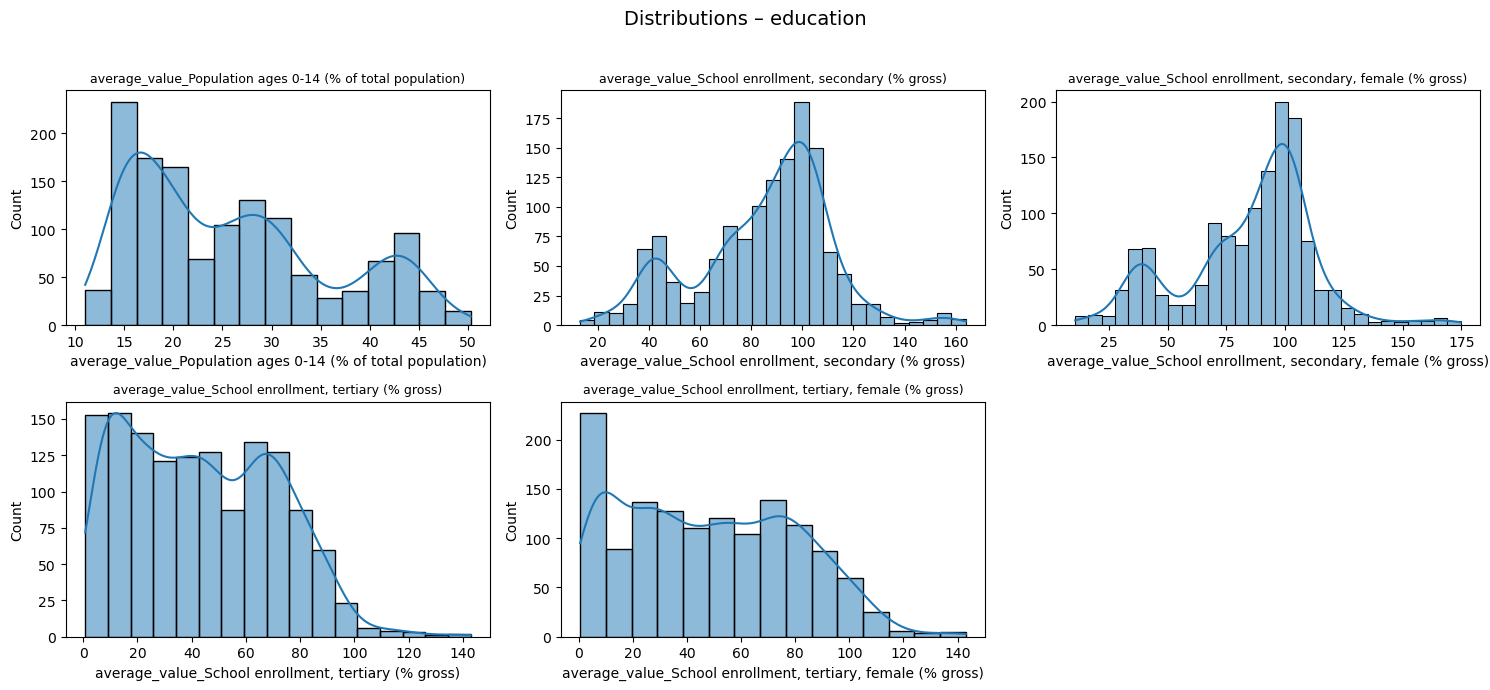


=== ECONOMY – Skewness (final selected indicators) ===


,skewness,abs_skew
average_value_GDP per capita (current US$),3.102,3.102
"average_value_GNI per capita, Atlas method (current US$)",2.240,2.240
"average_value_GDP per capita, PPP (current international $)",2.157,2.157
average_value_GDP growth (annual %),1.983,1.983
average_value_Gross domestic savings (% of GDP),-0.989,0.989


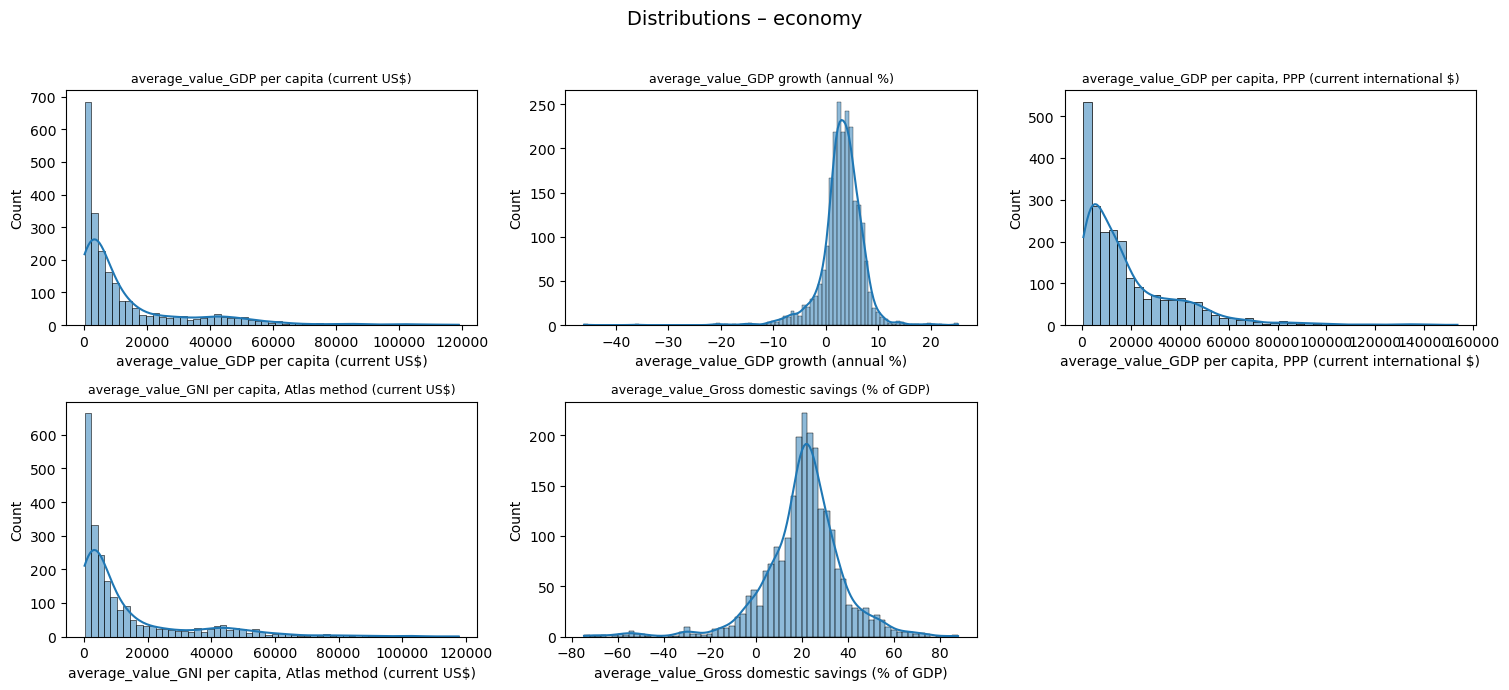


=== AGRICULTURE – Skewness (final selected indicators) ===


,skewness,abs_skew
"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",1.450,1.450
average_value_Forest area (% of land area),0.594,0.594
average_value_Rural population growth (annual %),-0.509,0.509
average_value_Agricultural land (% of land area),0.121,0.121
average_value_Rural population (% of total population),0.033,0.033


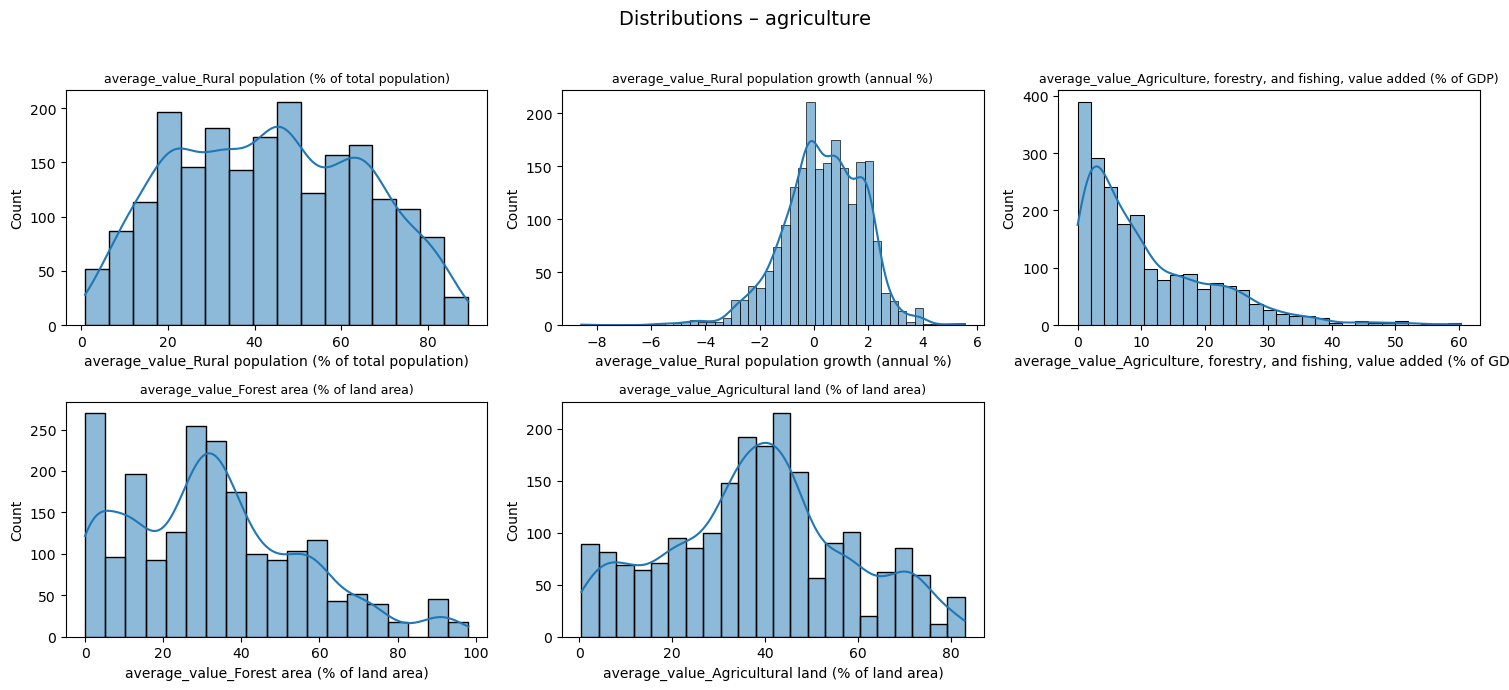


=== ENVIRONMENT – Skewness (final selected indicators) ===


,skewness,abs_skew
average_value_Total natural resources rents (% of GDP),2.556,2.556
average_value_People practicing open defecation (% of population),2.267,2.267
average_value_People using at least basic drinking water services (% of population),-1.337,1.337
average_value_People using at least basic sanitation services (% of population),-0.948,0.948
average_value_Adjusted savings: consumption of fixed capital (% of GNI),0.301,0.301


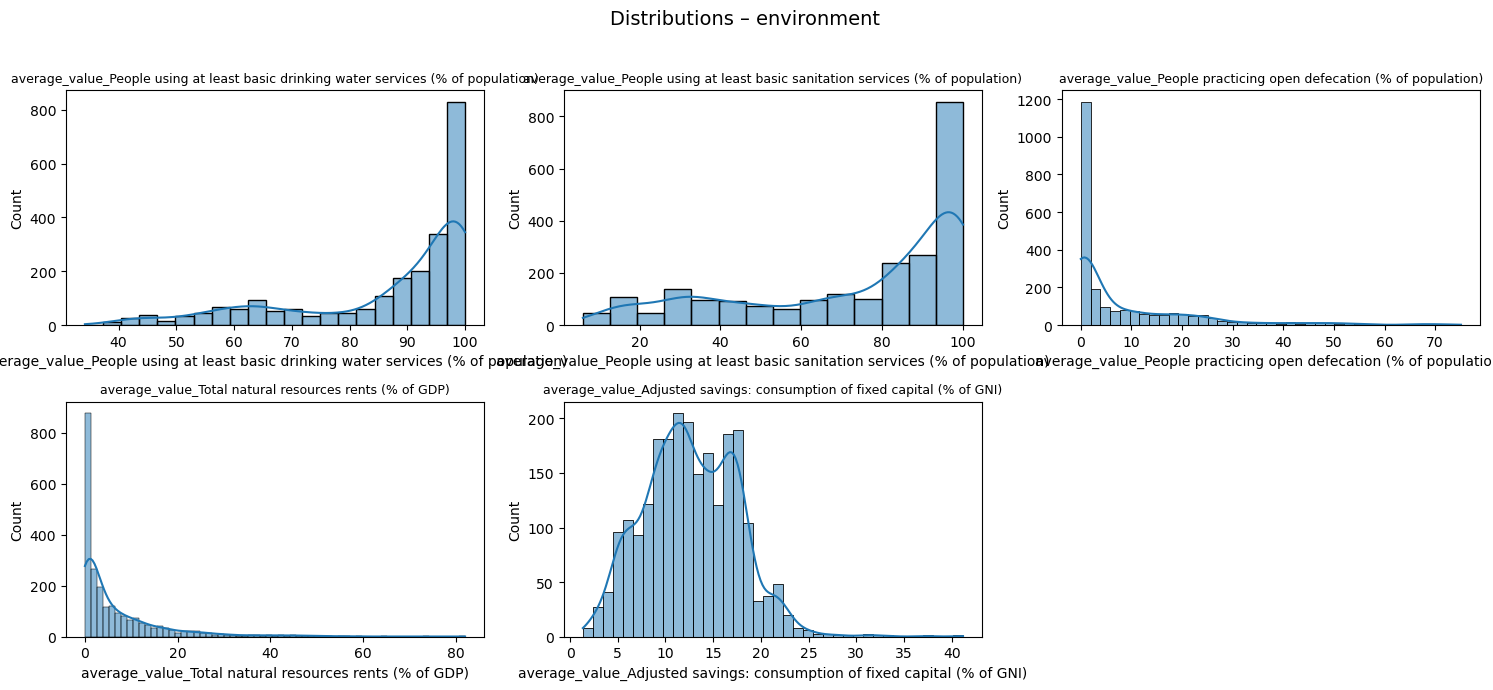


=== HEALTH – Skewness (final selected indicators) ===


,skewness,abs_skew
average_value_Population ages 65 and above (% of total population),0.883,0.883
average_value_Age dependency ratio (% of working-age population),0.683,0.683
average_value_Population growth (annual %),0.635,0.635
average_value_Population ages 15-64 (% of total population),-0.143,0.143


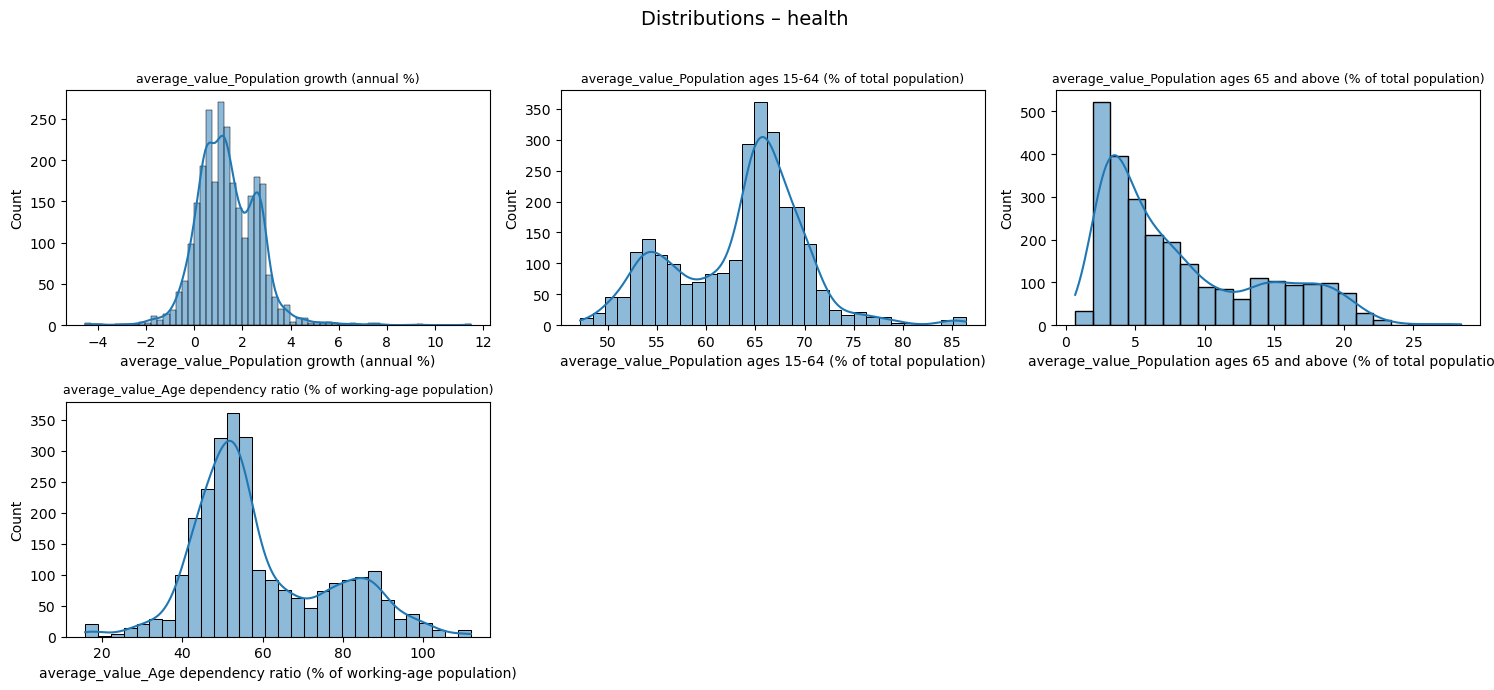


=== INFRASTRUCTURE – Skewness (final selected indicators) ===


,skewness,abs_skew
average_value_Fixed telephone subscriptions (per 100 people),1.589,1.589
average_value_Fixed broadband subscriptions (per 100 people),0.885,0.885
average_value_Mobile cellular subscriptions (per 100 people),0.489,0.489
average_value_Individuals using the Internet (% of population),0.056,0.056


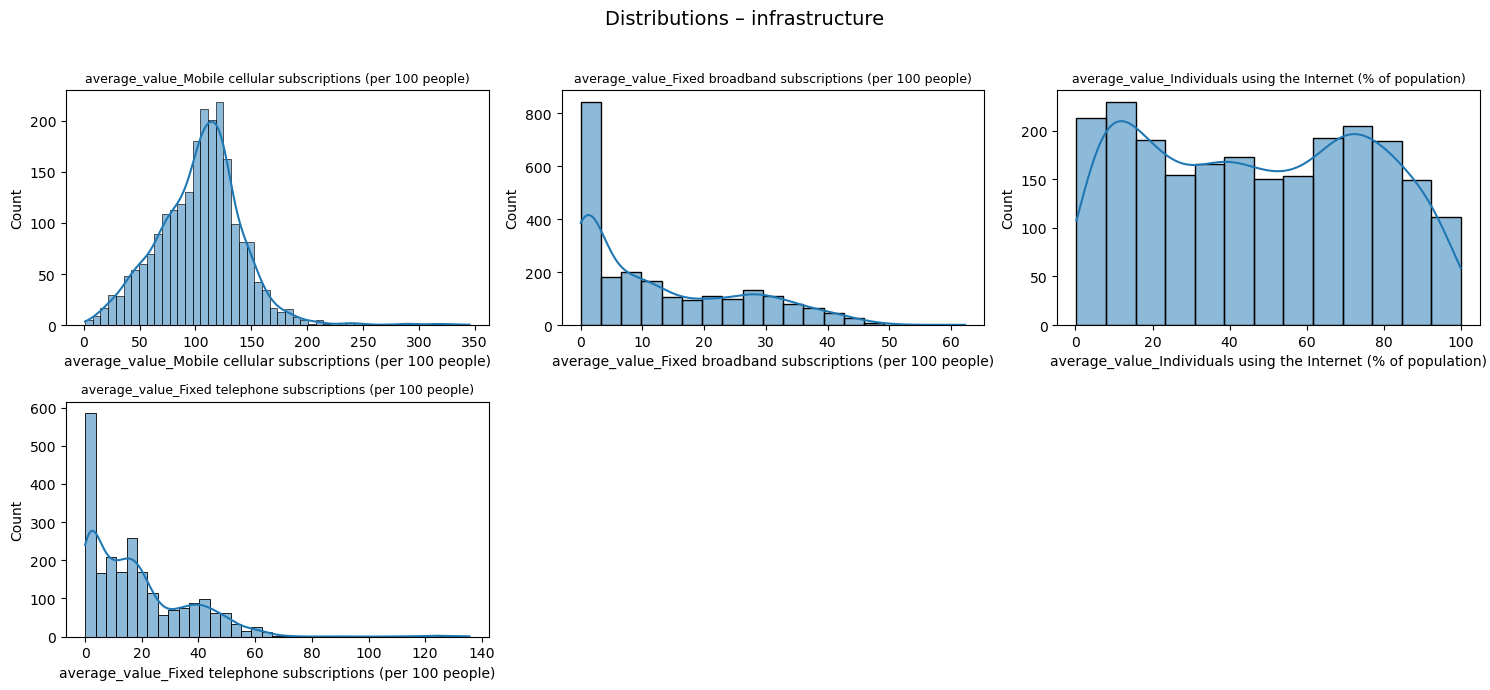

In [10]:
# Skewness tables and distribution plots

for domain, cols in selected_features.items():
    df = datasets[domain]
    display(skewness_table(df, cols, domain))
    plot_distributions(df, cols, domain)

### Merge finalised features into a single master dataset

In [11]:
from functools import reduce

reduced_dfs = {}

for domain, df in datasets.items():
    cols = ["Country Name", "Country Code"] + selected_features.get(domain, [])
    sub = df[cols].drop_duplicates(subset=["Country Name", "Country Code"])
    reduced_dfs[domain] = sub

list(reduced_dfs.keys())

['education',
 'economy',
 'agriculture',
 'environment',
 'health',
 'infrastructure']

In [12]:
dfs_to_merge = list(reduced_dfs.values())

master = reduce(
    lambda left, right: pd.merge(
        left, right, on=["Country Name", "Country Code"], how="inner"
    ),
    dfs_to_merge
)

print("Master dataset shape:", master.shape)
master.head()

Master dataset shape: (260, 30)


,Country Name,Country Code,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
0,Burundi,BDI,45.172568,26.122499,22.147461,NaN,NaN,305.549646,-3.900003,841.646026,260.000000,2.164416,87.92200,2.814011,30.680830,10.889408,79.166667,62.094321,45.745276,2.593233,9.212709,14.741276,3.128932,52.287257,2.312095,91.251201,56.649700,0.033745,5.200000,0.181569
1,Central African Republic,CAF,45.204811,NaN,NaN,NaN,NaN,424.449106,0.081071,720.324110,390.000000,2.247274,61.09600,0.783431,37.363580,36.282064,8.154355,41.276643,15.588241,24.877018,13.027198,18.515912,1.674662,53.265194,2.814790,87.739844,27.510630,0.016220,4.000000,0.043282
2,Djibouti,DJI,32.055328,40.860592,39.406471,5.345320,4.56802,2802.181971,6.652650,4692.550689,2870.000000,16.333296,22.08500,0.891831,1.271719,0.245902,NaN,75.787045,61.418905,17.152299,0.661011,11.688255,1.687132,65.126976,4.315132,53.546271,34.393042,2.643893,22.900000,2.505708
3,Fragile and conflict affected situations,FCS,40.561512,NaN,NaN,NaN,NaN,1928.978592,2.563330,4418.854110,2002.722766,NaN,59.04164,1.616129,NaN,23.709635,33.447002,64.519085,40.972965,19.207354,14.415440,10.347260,2.261211,55.574733,3.406058,81.388844,66.335890,1.478129,22.775050,2.617779
4,Croatia,HRV,14.511940,100.079773,102.458481,67.654228,79.05442,14609.524350,-0.198369,20804.388880,14040.000000,18.222707,44.84500,-0.600751,3.698754,34.310222,23.834882,NaN,96.565235,0.000000,NaN,NaN,-0.445070,64.206201,21.252235,55.748180,106.587440,25.113421,78.320933,31.669195


### Save master dataset for PCA & clustering

In [13]:
OUTPUT_PATH = DATA_DIR / "wdi_2010_2020_final_features.csv"
master.to_csv(OUTPUT_PATH, index=False)
print("Saved master dataset to:", OUTPUT_PATH)

Saved master dataset to: /Users/madhurabn/Desktop/unsupervised learning/data/wdi_2010_2020_final_features.csv


# Data Preprocessing & Feature Engineering

Steps included:
- Missingness check
- Skewness detection
- Log transform of skewed features
- Clipping extreme outliers
- Median imputation
- Standardization
- Save final preprocessed dataset

In [14]:
# Load Master Dataset

DATA_DIR = Path("/Users/madhurabn/Desktop/unsupervised learning/data")
MASTER_PATH = DATA_DIR / "wdi_2010_2020_final_features.csv"

master = pd.read_csv(MASTER_PATH)
master.head()

,Country Name,Country Code,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
0,Burundi,BDI,45.172568,26.122499,22.147461,NaN,NaN,305.549646,-3.900003,841.646026,260.000000,2.164416,87.92200,2.814011,30.680830,10.889408,79.166667,62.094321,45.745276,2.593233,9.212709,14.741276,3.128932,52.287257,2.312095,91.251201,56.649700,0.033745,5.200000,0.181569
1,Central African Republic,CAF,45.204811,NaN,NaN,NaN,NaN,424.449106,0.081071,720.324110,390.000000,2.247274,61.09600,0.783431,37.363580,36.282064,8.154355,41.276643,15.588241,24.877018,13.027198,18.515912,1.674662,53.265194,2.814790,87.739844,27.510630,0.016220,4.000000,0.043282
2,Djibouti,DJI,32.055328,40.860592,39.406471,5.345320,4.56802,2802.181971,6.652650,4692.550689,2870.000000,16.333296,22.08500,0.891831,1.271719,0.245902,NaN,75.787045,61.418905,17.152299,0.661011,11.688255,1.687132,65.126976,4.315132,53.546271,34.393042,2.643893,22.900000,2.505708
3,Fragile and conflict affected situations,FCS,40.561512,NaN,NaN,NaN,NaN,1928.978592,2.563330,4418.854110,2002.722766,NaN,59.04164,1.616129,NaN,23.709635,33.447002,64.519085,40.972965,19.207354,14.415440,10.347260,2.261211,55.574733,3.406058,81.388844,66.335890,1.478129,22.775050,2.617779
4,Croatia,HRV,14.511940,100.079773,102.458481,67.654228,79.05442,14609.524350,-0.198369,20804.388880,14040.000000,18.222707,44.84500,-0.600751,3.698754,34.310222,23.834882,NaN,96.565235,0.000000,NaN,NaN,-0.445070,64.206201,21.252235,55.748180,106.587440,25.113421,78.320933,31.669195


In [15]:
# Separate Metadata and Feature Matrix
meta_cols = ["Country Name", "Country Code"]
meta = master[meta_cols].copy()

X = master.drop(columns=meta_cols).copy()

X.shape, X.head()

((260, 28),
    average_value_Population ages 0-14 (% of total population)  average_value_School enrollment, secondary (% gross)  \
 0                                          45.172568                                                   26.122499      
 1                                          45.204811                                                         NaN      
 2                                          32.055328                                                   40.860592      
 3                                          40.561512                                                         NaN      
 4                                          14.511940                                                  100.079773      
 
    average_value_School enrollment, secondary, female (% gross)  average_value_School enrollment, tertiary (% gross)  \
 0                                          22.147461                                                           NaN     
 1                      

In [16]:
# Check Missingness & Skewness

print("Missingness (highest):")
print(X.isna().mean().sort_values(ascending=False).head(10))

print("\nSkewness (top absolute values):")
display(
    X.skew(numeric_only=True)
     .sort_values(key=lambda s: s.abs(), ascending=False)
     .to_frame("skewness")
     .round(3)
     .head(15)
)

Missingness (highest):
average_value_School enrollment, tertiary, female (% gross)                 0.492308
average_value_School enrollment, tertiary (% gross)                         0.484615
average_value_School enrollment, secondary, female (% gross)                0.407692
average_value_School enrollment, secondary (% gross)                        0.403846
average_value_Individuals using the Internet (% of population)              0.188462
average_value_Adjusted savings: consumption of fixed capital (% of GNI)     0.176923
average_value_Gross domestic savings (% of GDP)                             0.169231
average_value_Agricultural land (% of land area)                            0.165385
average_value_Total natural resources rents (% of GDP)                      0.146154
average_value_Agriculture, forestry, and fishing, value added (% of GDP)    0.119231
dtype: float64

Skewness (top absolute values):


,skewness
average_value_GDP per capita (current US$),3.223
average_value_GDP growth (annual %),-2.571
"average_value_GNI per capita, Atlas method (current US$)",2.318
average_value_Total natural resources rents (% of GDP),2.253
average_value_People practicing open defecation (% of population),2.078
"average_value_GDP per capita, PPP (current international $)",2.053
"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",1.449
average_value_People using at least basic drinking water services (% of population),-1.306
average_value_Fixed telephone subscriptions (per 100 people),1.293
average_value_Fixed broadband subscriptions (per 100 people),0.972


In [17]:
# Log-transform Skewed Features

skewness = X.skew(numeric_only=True)
skewed_cols = skewness[skewness > 1.0].index.tolist()

print("Columns to log1p:", skewed_cols)

X_log = X.copy()
X_log[skewed_cols] = np.log1p(X_log[skewed_cols])

# Check improvement
skew_after = X_log[skewed_cols].skew(numeric_only=True)
display(skew_after.to_frame("skew_after").round(3))

Columns to log1p: ['average_value_GDP per capita (current US$)', 'average_value_GDP per capita, PPP (current international $)', 'average_value_GNI per capita, Atlas method (current US$)', 'average_value_Agriculture, forestry, and fishing, value added (% of GDP)', 'average_value_People practicing open defecation (% of population)', 'average_value_Total natural resources rents (% of GDP)', 'average_value_Fixed telephone subscriptions (per 100 people)']


,skew_after
average_value_GDP per capita (current US$),0.060
"average_value_GDP per capita, PPP (current international $)",-0.189
"average_value_GNI per capita, Atlas method (current US$)",0.067
"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",-0.114
average_value_People practicing open defecation (% of population),0.536
average_value_Total natural resources rents (% of GDP),0.378
average_value_Fixed telephone subscriptions (per 100 people),-0.457


In [18]:
# Clip Extreme Outliers (1st–99th percentile)
lower = X_log.quantile(0.01)
upper = X_log.quantile(0.99)

X_clipped = X_log.clip(lower=lower, upper=upper, axis=1)
X_clipped.head()

,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
0,45.172568,26.122499,22.147461,NaN,NaN,6.013724,-3.900003,6.815012,6.027996,2.164416,84.56122,2.814011,3.455712,10.889408,79.166667,62.094321,45.745276,1.279052,2.323633,14.741276,3.128932,52.287257,2.312095,91.251201,56.649700,0.033745,5.200000,0.166844
1,45.204811,NaN,NaN,NaN,NaN,6.053145,0.081071,6.815012,6.027996,2.247274,61.09600,0.783431,3.647109,36.282064,8.154355,41.276643,15.588241,3.253355,2.640998,18.515912,1.674662,53.265194,2.814790,87.739844,27.510630,0.020273,4.000000,0.046202
2,32.055328,40.860592,39.406471,5.345320,4.56802,7.938510,6.652650,8.453945,7.962416,16.333296,22.08500,0.891831,0.820537,0.245902,NaN,75.787045,61.418905,2.898797,0.507426,11.688255,1.687132,65.126976,4.315132,53.546271,34.393042,2.643893,22.900000,1.254393
3,40.561512,NaN,NaN,NaN,NaN,7.565264,2.563330,8.393862,7.602762,NaN,59.04164,1.616129,NaN,23.709635,33.447002,64.519085,40.972965,3.006047,2.735370,10.347260,2.261211,55.574733,3.406058,81.388844,66.335890,1.478129,22.775050,1.285860
4,14.511940,100.079773,102.458481,67.654228,79.05442,9.589497,-0.198369,9.942967,9.549737,18.222707,44.84500,-0.600751,1.547297,34.310222,23.834882,NaN,96.565235,0.000000,NaN,NaN,-0.445070,64.206201,21.252235,55.748180,106.587440,25.113421,78.320933,3.486433


In [19]:
# Median Imputation
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_clipped)

X_imputed = pd.DataFrame(X_imputed, columns=X_clipped.columns, index=X_clipped.index)

X_imputed.isna().sum().sum()  # Should be 0


np.int64(0)

In [20]:
# Standardize Features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_imputed.columns, index=X_imputed.index)
X_scaled_df.head()

,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
0,1.706230,-2.830476,-2.878199,-0.107070,-0.080785,-1.959216,-1.627900,-2.302672,-2.016379,-1.307545,1.914180,1.749927,1.584200,-0.934730,2.355161,-1.591554,-1.096134,0.006484,0.988108,0.499365,1.578335,-1.858100,-1.052297,1.993895,-1.360694,-0.977155,-1.600235,-1.928190
1,1.709476,0.220998,0.229316,-0.107070,-0.080785,-1.930969,-0.626969,-2.302672,-2.016379,-1.301914,0.881698,0.316142,1.798048,0.188328,-1.553813,-2.898435,-2.203285,1.476175,1.297615,1.343481,0.331145,-1.696526,-0.961056,1.776127,-2.236294,-0.978182,-1.646406,-2.032602
2,0.385893,-2.120571,-2.081152,-1.778820,-1.796084,-0.580020,1.025275,-0.795047,-0.510979,-0.344549,-0.834807,0.392683,-1.360092,-1.405468,0.026936,-0.731960,-0.520710,1.212238,-0.783131,-0.183377,0.341839,0.263267,-0.688739,-0.344493,-2.029484,-0.778209,-0.919205,-0.986945
3,1.242097,0.220998,0.229316,-0.107070,-0.080785,-0.847468,-0.002872,-0.850316,-0.790868,-0.001161,0.791305,0.904107,0.022203,-0.367721,-0.161543,-1.439334,-1.271339,1.292076,1.389650,-0.483261,0.834172,-1.314946,-0.853739,1.382251,-1.069634,-0.867064,-0.924013,-0.959711
4,-1.379965,0.731904,0.830683,1.387866,1.506382,0.602985,-0.697226,0.574679,0.724303,-0.216135,0.166645,-0.661223,-0.548079,0.101118,-0.690656,0.458442,0.769612,-0.945656,-0.164364,-0.088991,-1.486748,0.111137,2.385400,-0.207934,0.139885,0.934423,1.213184,0.944825


In [21]:
# Save Preprocessed Dataset

output_path = DATA_DIR / "wdi_preprocessed_for_unsupervised.csv"

preprocessed_df = pd.concat([meta, X_scaled_df], axis=1)
preprocessed_df.to_csv(output_path, index=False)

output_path

PosixPath('/Users/madhurabn/Desktop/unsupervised learning/data/wdi_preprocessed_for_unsupervised.csv')

In [22]:
# Imports & Load Preprocessed Data

PREP_PATH = DATA_DIR / "wdi_preprocessed_for_unsupervised.csv"

df = pd.read_csv(PREP_PATH)
df.head()

,Country Name,Country Code,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
0,Burundi,BDI,1.706230,-2.830476,-2.878199,-0.107070,-0.080785,-1.959216,-1.627900,-2.302672,-2.016379,-1.307545,1.914180,1.749927,1.584200,-0.934730,2.355161,-1.591554,-1.096134,0.006484,0.988108,0.499365,1.578335,-1.858100,-1.052297,1.993895,-1.360694,-0.977155,-1.600235,-1.928190
1,Central African Republic,CAF,1.709476,0.220998,0.229316,-0.107070,-0.080785,-1.930969,-0.626969,-2.302672,-2.016379,-1.301914,0.881698,0.316142,1.798048,0.188328,-1.553813,-2.898435,-2.203285,1.476175,1.297615,1.343481,0.331145,-1.696526,-0.961056,1.776127,-2.236294,-0.978182,-1.646406,-2.032602
2,Djibouti,DJI,0.385893,-2.120571,-2.081152,-1.778820,-1.796084,-0.580020,1.025275,-0.795047,-0.510979,-0.344549,-0.834807,0.392683,-1.360092,-1.405468,0.026936,-0.731960,-0.520710,1.212238,-0.783131,-0.183377,0.341839,0.263267,-0.688739,-0.344493,-2.029484,-0.778209,-0.919205,-0.986945
3,Fragile and conflict affected situations,FCS,1.242097,0.220998,0.229316,-0.107070,-0.080785,-0.847468,-0.002872,-0.850316,-0.790868,-0.001161,0.791305,0.904107,0.022203,-0.367721,-0.161543,-1.439334,-1.271339,1.292076,1.389650,-0.483261,0.834172,-1.314946,-0.853739,1.382251,-1.069634,-0.867064,-0.924013,-0.959711
4,Croatia,HRV,-1.379965,0.731904,0.830683,1.387866,1.506382,0.602985,-0.697226,0.574679,0.724303,-0.216135,0.166645,-0.661223,-0.548079,0.101118,-0.690656,0.458442,0.769612,-0.945656,-0.164364,-0.088991,-1.486748,0.111137,2.385400,-0.207934,0.139885,0.934423,1.213184,0.944825


In [23]:
# Separate Metadata and Features

meta = df[["Country Name", "Country Code"]].copy()
X = df.drop(columns=["Country Name", "Country Code"]).copy()

X.shape

(260, 28)

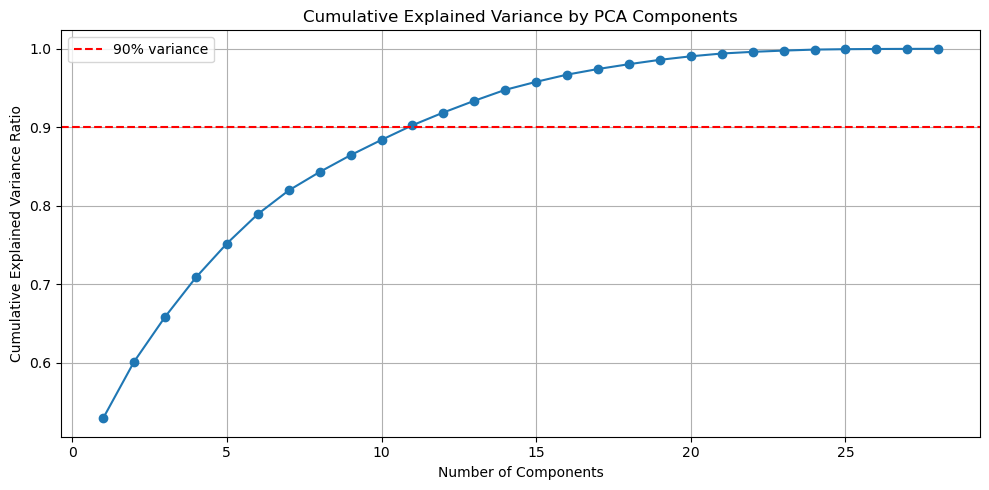

,component,explained_variance_ratio,cumulative_variance
0,1,0.529097,0.529097
1,2,0.072071,0.601169
2,3,0.057057,0.658226
3,4,0.050410,0.708636
4,5,0.043183,0.751818
5,6,0.037482,0.789300
6,7,0.030173,0.819474
7,8,0.023510,0.842984
8,9,0.021438,0.864421
9,10,0.019515,0.883936


In [24]:
# PCA – Explained Variance

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X)

explained = pca_full.explained_variance_ratio_
cum_var = explained.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% variance')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

explained_df = pd.DataFrame({
    "component": np.arange(1, len(explained) + 1),
    "explained_variance_ratio": explained,
    "cumulative_variance": cum_var
})
explained_df.head(10)

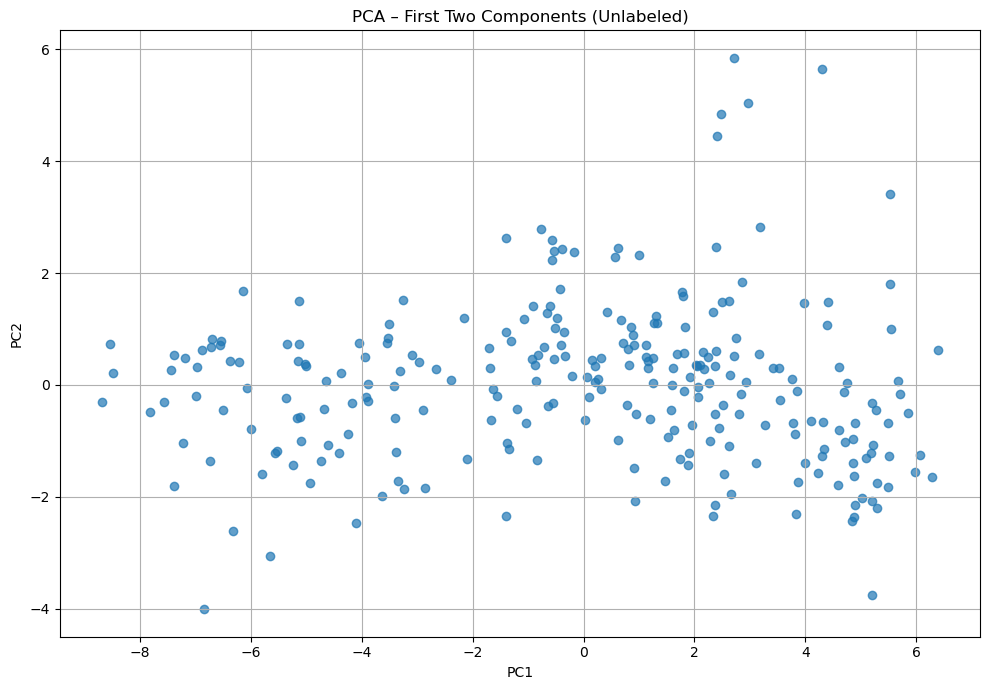

In [25]:
# PCA – 2D Projection

# Choose 2 components for visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

df_pca2 = pd.DataFrame(X_pca2, columns=["PC1", "PC2"])
df_pca2 = pd.concat([meta, df_pca2], axis=1)

plt.figure(figsize=(10, 7))
plt.scatter(df_pca2["PC1"], df_pca2["PC2"], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – First Two Components (Unlabeled)")
plt.grid(True)
plt.tight_layout()
plt.show()

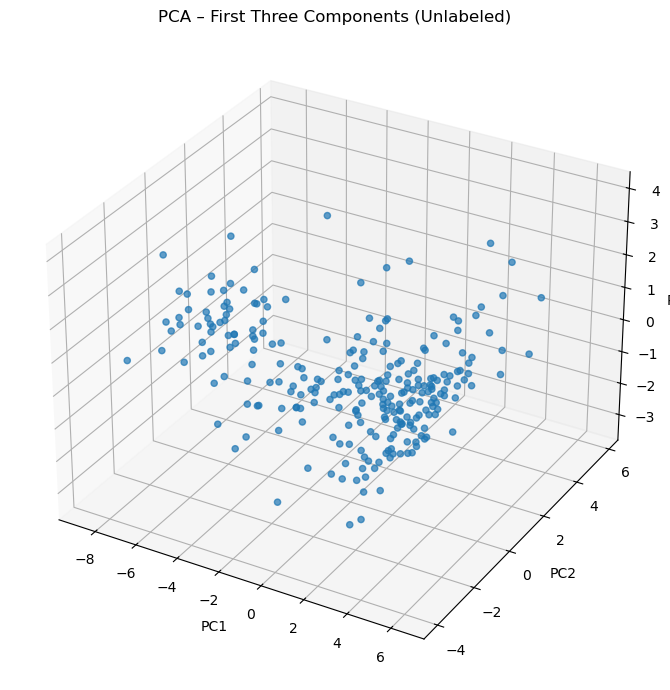

In [26]:
# PCA – 3D Projection

from mpl_toolkits.mplot3d import Axes3D  # ensure imported

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], alpha=0.7)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA – First Three Components (Unlabeled)")
plt.tight_layout()
plt.show()

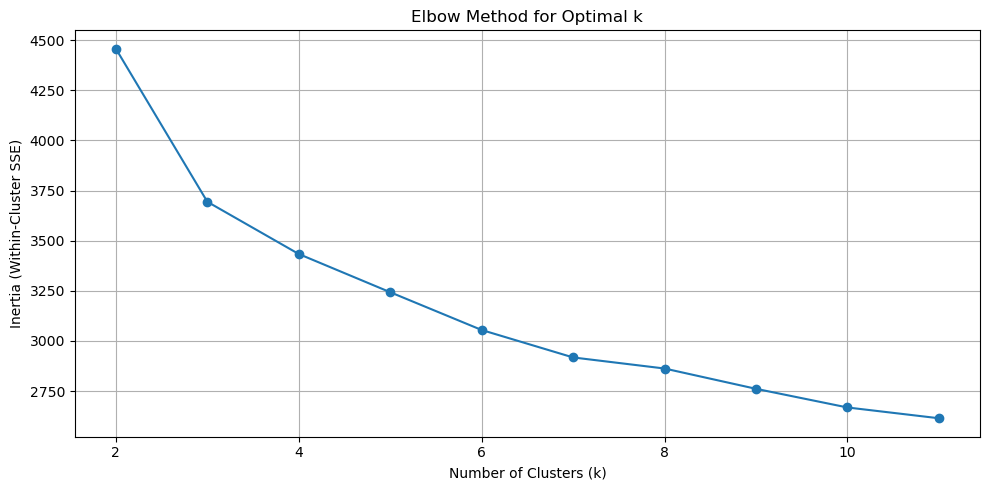

In [27]:
# K-Means – Elbow Method (Inertia)


inertia = []
K_range = range(2, 12)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(list(K_range), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Fit Final K-Means Model and Assign Clusters

# Set this manually after inspecting elbow & silhouette plots
best_k = 4  # <-- CHANGE THIS after you inspect results

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

df["Cluster"] = cluster_labels
meta["Cluster"] = cluster_labels

df.head()

,Country Name,Country Code,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people),Cluster
0,Burundi,BDI,1.706230,-2.830476,-2.878199,-0.107070,-0.080785,-1.959216,-1.627900,-2.302672,-2.016379,-1.307545,1.914180,1.749927,1.584200,-0.934730,2.355161,-1.591554,-1.096134,0.006484,0.988108,0.499365,1.578335,-1.858100,-1.052297,1.993895,-1.360694,-0.977155,-1.600235,-1.928190,3
1,Central African Republic,CAF,1.709476,0.220998,0.229316,-0.107070,-0.080785,-1.930969,-0.626969,-2.302672,-2.016379,-1.301914,0.881698,0.316142,1.798048,0.188328,-1.553813,-2.898435,-2.203285,1.476175,1.297615,1.343481,0.331145,-1.696526,-0.961056,1.776127,-2.236294,-0.978182,-1.646406,-2.032602,3
2,Djibouti,DJI,0.385893,-2.120571,-2.081152,-1.778820,-1.796084,-0.580020,1.025275,-0.795047,-0.510979,-0.344549,-0.834807,0.392683,-1.360092,-1.405468,0.026936,-0.731960,-0.520710,1.212238,-0.783131,-0.183377,0.341839,0.263267,-0.688739,-0.344493,-2.029484,-0.778209,-0.919205,-0.986945,2
3,Fragile and conflict affected situations,FCS,1.242097,0.220998,0.229316,-0.107070,-0.080785,-0.847468,-0.002872,-0.850316,-0.790868,-0.001161,0.791305,0.904107,0.022203,-0.367721,-0.161543,-1.439334,-1.271339,1.292076,1.389650,-0.483261,0.834172,-1.314946,-0.853739,1.382251,-1.069634,-0.867064,-0.924013,-0.959711,3
4,Croatia,HRV,-1.379965,0.731904,0.830683,1.387866,1.506382,0.602985,-0.697226,0.574679,0.724303,-0.216135,0.166645,-0.661223,-0.548079,0.101118,-0.690656,0.458442,0.769612,-0.945656,-0.164364,-0.088991,-1.486748,0.111137,2.385400,-0.207934,0.139885,0.934423,1.213184,0.944825,0


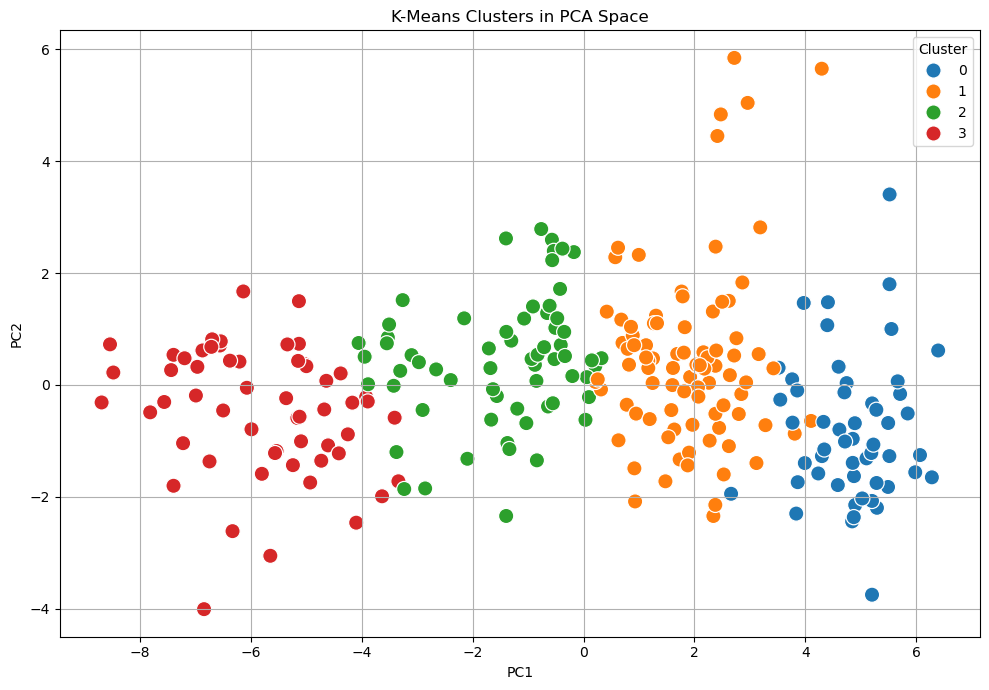

In [29]:
# PCA 2D Visualization Colored by Cluster

# Reuse df_pca2 and add clusters
df_pca2_clusters = df_pca2.copy()
df_pca2_clusters["Cluster"] = cluster_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pca2_clusters,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=120
)
plt.title("K-Means Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Cluster Centers (in Standardized Feature Space)

centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X.columns
)
centers.index.name = "Cluster"
centers

,average_value_Population ages 0-14 (% of total population),"average_value_School enrollment, secondary (% gross)","average_value_School enrollment, secondary, female (% gross)","average_value_School enrollment, tertiary (% gross)","average_value_School enrollment, tertiary, female (% gross)",average_value_GDP per capita (current US$),average_value_GDP growth (annual %),"average_value_GDP per capita, PPP (current international $)","average_value_GNI per capita, Atlas method (current US$)",average_value_Gross domestic savings (% of GDP),average_value_Rural population (% of total population),average_value_Rural population growth (annual %),"average_value_Agriculture, forestry, and fishing, value added (% of GDP)",average_value_Forest area (% of land area),average_value_Agricultural land (% of land area),average_value_People using at least basic drinking water services (% of population),average_value_People using at least basic sanitation services (% of population),average_value_People practicing open defecation (% of population),average_value_Total natural resources rents (% of GDP),average_value_Adjusted savings: consumption of fixed capital (% of GNI),average_value_Population growth (annual %),average_value_Population ages 15-64 (% of total population),average_value_Population ages 65 and above (% of total population),average_value_Age dependency ratio (% of working-age population),average_value_Mobile cellular subscriptions (per 100 people),average_value_Fixed broadband subscriptions (per 100 people),average_value_Individuals using the Internet (% of population),average_value_Fixed telephone subscriptions (per 100 people)
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.140791,0.916817,0.892486,1.419694,1.403912,1.214974,-0.231474,1.193622,1.294258,0.399730,-0.872439,-0.457131,-1.106808,0.114994,-0.160674,0.742570,0.818469,-0.907691,-0.833342,0.865184,-0.704147,0.487483,1.525966,-0.515714,0.623626,1.382069,1.231456,1.009743
1,-0.510977,0.338360,0.346288,-0.031088,0.001702,0.425771,-0.240048,0.429402,0.333744,0.054283,-0.415054,-0.456429,-0.330931,0.030581,-0.126394,0.575453,0.590617,-0.583221,-0.155302,-0.020620,-0.370932,0.724420,0.083356,-0.704656,0.509546,0.197193,0.344530,0.529755
2,0.361800,-0.213493,-0.181682,-0.431318,-0.444407,-0.438995,0.352298,-0.383192,-0.387323,0.132654,0.391044,0.144101,0.417482,0.017279,-0.041897,0.032313,-0.085622,0.392400,0.224199,-0.281225,0.171550,-0.062585,-0.552545,-0.001670,-0.344383,-0.612066,-0.481016,-0.270549
3,1.448785,-1.139046,-1.165267,-0.776499,-0.798413,-1.295550,0.189532,-1.345203,-1.283612,-0.608084,1.015443,0.977038,1.070662,-0.174583,0.395699,-1.630741,-1.590266,1.310888,0.761635,-0.449583,1.040687,-1.519511,-0.916477,1.588103,-0.986216,-0.893721,-1.135168,-1.460892


In [31]:
# World Map Visualization of Clusters

# This cell uses plotly for an interactive world map.
# Install plotly in your environment if needed: pip install plotly

import plotly.express as px

map_df = meta.copy()

fig = px.choropleth(
    map_df,
    locations="Country Code",
    color="Cluster",
    hover_name="Country Name",
    projection="natural earth",
    color_continuous_scale="Viridis",
    title="Country Clusters (K-Means)"
)
fig.show()

### Results and Conclusion:

This analysis applied PCA and K-Means clustering to 2010–2020 World Development Indicators after comprehensive feature selection and preprocessing.

Key findings:

1. PCA revealed that global socioeconomic variation is dominated by a single underlying dimension, with PC1 explaining ~53% of total variance.
This axis corresponds closely to overall “development level” — combining income, education, infrastructure, and health conditions.

2. PC2 and PC3 captured additional differences related to resource dependence, agricultural structure, and demographic patterns.

3. Using elbow and silhouette methods, four clusters (k = 4) provided the best balance between compactness and separation.

4. K-Means identified four meaningful country groups, which align well with known global development categories:

   1. High-income, advanced digital economies

   2. Emerging industrializing economies

   3. Lower-income agrarian economies

   4. Resource-rich export economies

5. PCA scatterplots and world map visualisation further confirmed clear structure in global development patterns.

   

#### Overall Conclusion: 

This project showed that unsupervised learning can naturally find patterns in global development data. Even without labels, here the countries grouped based on things like income levels, education, health, infrastructure, and agriculture.

Using PCA helped reduce the complexity and shows the main differences between countries. K-Means then formed clear clusters that make sense in the real world, such as high-income nations, emerging economies, agricultural countries, and resource-rich countries.

Overall, PCA and K-Means worked well together and gave a clear picture of how countries are similar or different. These results can be useful for understanding global trends and exploring how countries change over time.